# CTR Analysis Ver3
from 24/04/10

In [12]:
%reset -f
import numpy as np
# from scipy.constants import h, c, e, pi
# from scipy.linalg import inv
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
from fractions import Fraction
import traceback

In [13]:
exp  = lambda rad: np.exp(rad)
sin  = lambda rad: np.sin(rad)
cos  = lambda rad: np.cos(rad)
tan  = lambda rad: np.tan(rad)
asin = lambda rad: np.arcsin(rad)
acos = lambda rad: np.arccos(rad)
#
sqrt   = lambda vec: np.sqrt(vec)
norm   = lambda vec: np.linalg.norm(vec)
square = lambda vec: np.power(vec, 2)
def vec(*args): return np.array([*args])
def uvec(*args): 
    vec = np.array([*args])
    return  vec / np.linalg.norm(vec)
#
pi   = np.pi
inf  = np.inf
#
eps0 = 8.854187817E-12

In [14]:
def cube3d(arr, dim=0b001):
    if dim == 0b100:   return np.transpose(np.array(arr),(0, 2, 1))[:,:,::-1]
    elif dim == 0b010: return np.transpose(np.array(arr),(2, 0, 1))[::-1,:,::-1]
    elif dim == 0b001: return np.transpose(np.array(arr),(1, 2, 0))[:,:,::-1]
    else: return

def cuberange(X, Y, Z):
    for i in range(X):
        for j in range(Y):
            for k in range(Z):
                yield (i, j, k)

def span(eigenValues, eigenVector):
    return np.tensordot(eigenValues, eigenVector, axes=0)


In [15]:
def PIticks(start, end, step):
    v = np.arange(start, end+step, step)
    txt = []
    for ii in v:
        f = Fraction(ii)
        if f==0:
            txt.append(0)
            continue
        #
        if   f.numerator ==  1: num = 'π'
        elif f.numerator == -1: num = '-π'
        else: num = f'{f.numerator}π'
        #
        if f.denominator == 1: txt.append(num)
        else : txt.append(f'{num}/{f.denominator}')
    return v*pi, txt

# 
---

In [16]:
# https://lampz.tugraz.at/~hadley/ss1/crystaldiffraction/atomicformfactors/formfactors.php
AtomicFormFactor = {
	#		a1		b1		a2		b2		a3		b3		a4		b4		c		
	'Sr'  : [17.5663, 1.5564, 9.8184, 14.0988, 5.422, 0.1664, 2.6694, 132.376, 2.5064],
	'Sr2+': [18.0874, 1.4907, 8.1373, 12.6963, 2.5654, 24.5651, -34.193, -0.0138, 41.4025],
	'Ti'  : [9.7595, 7.8508, 7.3558, 0.5, 1.6991, 35.6338, 1.9021, 116.105, 1.2807],
	'Ti2+': [9.11423, 7.5243, 7.62174, 0.457585, 2.2793, 19.5361, 0.087899, 61.6558, 0.897155],
	'Ti3+': [17.7344, 0.22061, 8.73816, 7.04716, 5.25691, -0.15762, 1.92134, 15.9768, -14.652],
    'Ti4+': [19.5114, 0.178847, 8.23473, 6.67018, 2.01341, -0.29263, 1.5208, 12.9464, -13.28],
    'O'   : [3.0485, 13.2771, 2.2868, 5.7011, 1.5463, 0.3239, 0.867, 32.9089, 0.2508],
    'O1-' : [4.1916, 12.8573, 1.63969, 4.17236, 1.52673, 47.0179, -20.307, -0.01404, 21.9412],
	'Ru'  : [19.2674, 0.80852, 12.9182, 8.43467, 4.86337, 24.7997, 1.56756, 94.2928, 5.37874],
    'Ru3+': [18.5638, 0.847329, 13.2885, 8.37164, 9.32602, 0.017662, 3.00964, 22.887, -3.1892],
    'Ru4+': [18.5003, 0.844582, 13.1787, 8.12534, 4.71304, 0.36495, 2.18535, 20.8504, 1.42357],
    'Nd'  : [22.6845, 2.66248, 19.6847, 0.210628, 12.774, 15.885, 2.85137, 137.903, 1.98486],
    'Nd3+': [21.961, 2.52722, 19.9339, 0.199237, 12.12, 14.1783, 1.51031, 30.8717, 1.47588],
    'Ni'  : [12.8376, 3.8785, 7.292, 0.2565, 4.4438, 12.1763, 2.38, 66.3421, 1.0341],
    'Ni2+': [11.4166, 3.6766, 7.4005, 0.2449, 5.3442, 8.873, 0.9773, 22.1626, 0.8614],
    'Ni3+': [10.7806, 3.5477, 7.75868, 0.22314, 5.22746, 7.64468, 0.847114, 16.9673, 0.386044],
    'Ga'  : [15.2354, 3.0669, 6.7006, 0.2412, 4.3591, 10.7805, 2.9623, 61.4135, 1.7189],
    'Ga3+': [12.692, 2.81262, 6.69883, 0.22789, 6.06692, 6.36441, 1.0066, 14.4122, 1.53545]
}

---

In [17]:
class Xray():
    CuKa1 = 1.5406
    def __init__(self, wavelength = 1.5406):
        self.wavelength = wavelength # Å unit
        self.K = 2 * pi / wavelength
    def __call__(self, *args):
        if len(args)>0:
            return Lattice(self, *args)
        else: return self.K
    def tthetas2dks(self, tthetas):
        return 2 * self.K * sin(tthetas/2)

# Usage
CuKa1 = Xray(Xray.CuKa1)

In [18]:
class Atom():
	def __init__(self, Z, def_name = None):
		self.Z = Z
		if def_name == None:
			(_,_,_,text)=traceback.extract_stack()[-2]
			def_name = text[:text.find('=')].strip()
		self.def_name = def_name
	def __call__(self):
		return self.def_name
	def __truediv__(self, num):
		return Atom(self.Z / num.Z, def_name=self.def_name)

# Usage
Sr = Atom(38)
Ti = Atom(22)
O  = Atom(8)
Ru = Atom(44)
Nd = Atom(60)
Ni = Atom(28)
Ga = Atom(31)

In [19]:
class Molecule():
    def __init__(self, structure, abc, def_name = None):
        self.structure = structure
        self.abc = vec(*abc)
        if def_name == None:
            (_,_,_,text)=traceback.extract_stack()[-2]
            def_name  = text[:text.find('=')].strip()
        self.def_name = def_name
    def __call__(self, *args):
        if len(args)>0:
            return {self.def_name: vec(*args)}
        return self.def_name
    #
    def perovskite(A, B, O): # Atoms
        A /= Atom(8)
        O /= Atom(2)
        return cube3d([
            [[A, 0, A], [0, O, 0], [A, 0, A]],
            [[0, O, 0], [O, B, O], [0, O, 0]],
            [[A, 0, A], [0, O, 0], [A, 0, A]]
        ], 0b100)
    def pseudocubic(*abc):
        a, b, c = abc
        ac      = np.sqrt(a**2 + b**2) / 2
        cc      = c / 2
        return np.array((ac, ac, cc))
    def const_volume_abc(self, film_abc):
        a, b, _ = self.abc
        return np.array([a, b, np.prod(film_abc) / (a*b)])
    def strain(self, film):
        return Molecule(
			structure = film.structure,
			abc = self.const_volume_abc(film.abc)
		)
    def __truediv__(self, substrate):
        return Molecule(
			structure = self.structure,
			abc = substrate.const_volume_abc(self.abc),
            def_name  = self.def_name + '/' + substrate.def_name
    )
    #
    def GG2HKL(self, GG, nref=vec(0,0,1)):
        nref = uvec(*nref)
        QQ   = span(GG, nref)
        # Q * abc = 2 * pi * hkl
        HKL = QQ * self.abc / 2 / pi
        return HKL
    # def hkls2Gs(self, hkls):
    #     return np.linalg.norm(2 * pi * hkls / self.abc , axis = 1)

# Usage
sto = Molecule(
    structure = Molecule.perovskite(Sr, Ti, O),
    abc = (3.905, 3.905, 3.905)
)
sro = Molecule(
    structure = Molecule.perovskite(Sr, Ru, O),
    abc = Molecule.pseudocubic(5.567, 5.5304, 7.8446)
)
nno = Molecule(
    structure = Molecule.perovskite(Nd, Ni, O),
    abc = Molecule.pseudocubic(5.387, 5.383, 7.610)
)
ngo = Molecule(
    structure = Molecule.perovskite(Nd, Ni, O),
    abc = Molecule.pseudocubic(5.428, 5.498, 7.708)
)
sro_sto = sro/sto # sto.strain(sro)
nno_sto = nno/sto # sto.strain(nno)
ngo_sto = ngo/sto # sto.strain(ngo)

In [20]:
class Film():
    def __init__(self, molecule, NaNbNc, configuration = []):
        self.molecule = molecule
        self.NaNbNc = NaNbNc
        self.Na, self.Nb, self.Nc = NaNbNc
        #
        self.configuration = configuration
    def __call__(self):
        return self.molecule()
    def __truediv__(self, substrate):
        return Film(self.molecule, self.NaNbNc, [*self.configuration, substrate])
    
class Sample():
    def __init__(self, top_film):
        if top_film.configuration == []:
            self.films = [top_film]
        else:
            self.films = [top_film, *top_film.configuration]
        self.bulk = self.films.pop()
    def __call__(self):
        return vec(*[x() for x in self.films], self.bulk())

# Usage
STO = Film(sto, (10, 10, 100))
SRO = Film(sro, (10, 10, 10))
NNO = Film(nno, (10, 10, 10))
NGO = Film(ngo, (10, 10, 10))
#
SRO_sto = Film(sro/sto, (10, 10, 100))
#
SRO_STO = Sample(SRO_sto/STO)
NNO_SRO_STO = Sample(NNO/SRO/STO)

# SAMP = Sample(SRO)
print('Total Configuration )')
print(NNO_SRO_STO())
print(f'BULK )  {NNO_SRO_STO.bulk()}')
print(f'FILM )  {vec(*[x() for x in NNO_SRO_STO.films])}')

Total Configuration )
['nno' 'sro' 'sto']
BULK )  sto
FILM )  ['nno' 'sro']


In [21]:
class Detector:
    def __init__(self, xray, atom=[], molecule=[], film=[], sample=[]):
        if str(atom.__class__) == "<class '__main__.Atom'>": self.atom = vec(atom)
        else : self.atom = vec(*atom)
        #
        if str(molecule.__class__) == "<class '__main__.Molecule'>": self.molecule = vec(molecule)
        else: self.molecule = vec(*molecule)

        self.film     = film
        self.sample   = sample
        #
        self.TTHETA   = np.linspace(0, pi, 1000)
        self.DK       = xray.tthetas2dks(self.TTHETA)
        self.nref     = {}

    def align(self, nref):
        # nref = {'sto': (0, 0, 1)}  또는  sto(0, 0, 1)
        if str(nref.__class__) == "<class 'dict'>":
            self.nref = nref
        # nref = [sto(0,0,1), nno(0,0,2)]
        elif str(nref[0].__class__) == "<class 'dict'>":
            self.nref = dict((key, value) for dictionary in nref for key, value in dictionary.items())
        # nref = (0,0,1)
        elif len(self.molecule) == 1:
            self.nref = {self.molecule[0]() : vec(*nref)}
        elif not len(self.molecule) == len(nref):
            print("ERROR_")
            print("SHOULD BE) len(self.molecule) == len(nref):")
        # nref = [(0,0,1), (0,0,2)]
        else :
            res = {}
            for ii in range(len(self.molecule)):
                res[self.molecule[ii]()] = nref[ii]
            self.nref = vec(*res)

    def tthetaChange(self, ttheta):
        self.TTHETA = ttheta
        self.DK     = self.xray.tthetas2dks(ttheta)
    
    # Atomic Form Factor
    def AFF(self, REF=True):
        res = []
        for atom in self.atom:
            if REF:
                (a1, b1, a2, b2, a3, b3, a4, b4, c) = AtomicFormFactor[atom.def_name]
                res.append(sum(c + vec(*[a * exp(-1 * b * np.power(self.DK/(4*pi), 2)) for a, b in zip(vec(a1, a2, a3, a4), vec(b1, b2, b3, b4))])))
            else:
                res.append(atom.Z / np.power(self.DK, 2))
        if self.atom.size == 1: return res[0]
        else : return vec(*res)
        
    # Structure Factor
    def SF(self, REF = True):
        if not len(self.nref.keys()):
            print("ERROR_")
            print("You need to set the scan orientation first.")
            print("EX) Detector.align(self, nref)")
            return
        res = []
        for molecule in self.molecule:
            structure = molecule.structure 
            hkls = molecule.GG2HKL(self.DK, nref=self.nref[molecule()])
            # G = np.linalg.norm(2 * pi * hkls / molecule.abc, axis = 1)
            (Nx, Ny, Nz) = len(structure[:,0,0]),len(structure[0,:,0]),len(structure[0,0,:])
            sf = np.zeros(len(hkls))
            for (ii,jj,kk) in cuberange(Nx,Ny,Nz):
                if structure[ii,jj,kk]==0 : continue
                # rj는 sample의 abc 프레임 기준..
                rj = vec(ii,jj,kk) / vec(Nx-1, Ny-1, Nz-1)
                #
                self.atom = vec(structure[ii,jj,kk])
                sf = sf + self.AFF(REF) * exp(2j * pi * hkls @ rj)
            res.append(sf)
        if self.molecule.size == 1: return res[0]
        return vec(*res)

---

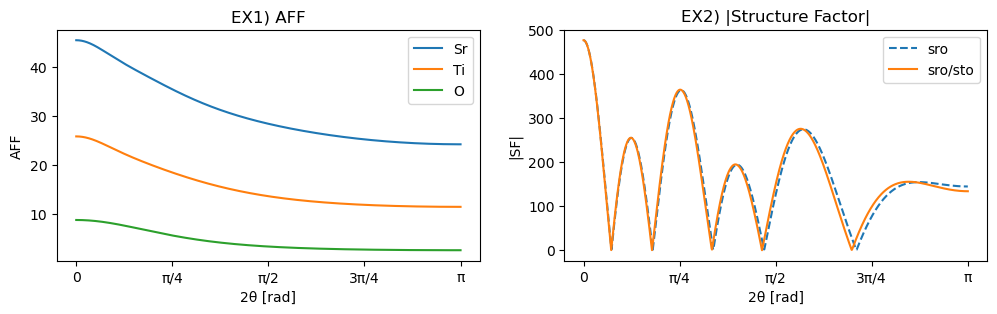

In [22]:
plt.figure(figsize=(12,3))
def EX1_AFF():
    XRD = Detector(CuKa1, atom = [Sr, Ti, O])
    AFF = XRD.AFF(REF=True)
    plt.subplot(1,2,1)
    plt.plot(XRD.TTHETA, AFF[0], label='Sr')
    plt.plot(XRD.TTHETA, AFF[1], label='Ti')
    plt.plot(XRD.TTHETA, AFF[2], label='O')
    plt.xticks(*PIticks(0, 1, 1/4))
    plt.legend()
    plt.xlabel('2θ [rad]')
    plt.ylabel('AFF')
    plt.title(f'EX1) AFF')
EX1_AFF()
def EX2_SF():
    XRD = Detector(CuKa1, molecule=[sro, sro_sto])
    XRD.align(nref = [sro(0,0,1), sro_sto(0,0,1)])
    SF  = XRD.SF()
    plt.subplot(1,2,2)
    plt.plot(XRD.TTHETA, np.abs(SF[0]), label='sro', linestyle='dashed')
    plt.plot(XRD.TTHETA, np.abs(SF[1]), label='sro/sto')
    plt.legend()
    plt.xticks(*PIticks(0, 1, 1/4))
    plt.xlabel('2θ [rad]')
    plt.ylabel('|SF|')
    plt.title(f'EX2) |Structure Factor|')
EX2_SF()